In [1]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.image import grid_to_graph
import scipy
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm
import random
from scipy.stats import sem
import time
import h5py
import ants
import nibabel as nib
import matplotlib
from scipy.ndimage import gaussian_filter1d
from scipy.fftpack import fft,fftshift,ifft
from scipy import signal
import pickle
from matplotlib.colors import Normalize
import cv2
import tqdm

/home/users/brezovec/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning: Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function
  "Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function"


In [3]:
# fly = 312
# func = 'func_0'
# load_directory = f'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_{fly}/{func}'
# brain_file = os.path.join(load_directory, 'functional_channel_2_moco_zscore.h5')
# with h5py.File(brain_file, 'r') as hf:
#     brain = hf['data'][:]
# brain.shape

(124, 32, 16, 5098)

In [32]:
fly = 312
func = 'func_0'
load_directory = f'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_{fly}/{func}/imaging/'
brain_file = os.path.join(load_directory, 'functional_channel_1_mean.nii')
brain = ants.image_read(brain_file).numpy()
brain.shape



(124, 32, 16)

In [113]:
fly = 316
func = 'func_0'
load_directory = f'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_{fly}/{func}/imaging'
brain_file = os.path.join(load_directory, 'functional_channel_2.nii')
brain = ants.image_read(brain_file).numpy()
print(brain.shape)

load_directory = f'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_{fly}/{func}'


(111, 41, 15, 13600)


In [5]:
fly = 312
func = 'func_0'
load_directory = f'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_{fly}/{func}/moco'
brain_file = os.path.join(load_directory, 'functional_channel_2_moco.h5')
with h5py.File(brain_file, 'r') as hf:
    brain_MOCO = hf['data'][:]
brain_MOCO.shape

(124, 32, 16, 5098)

In [6]:
brain_OG[60,15,10,1000], brain_MOCO[60,15,10,1000]

(31.0, 0.0)

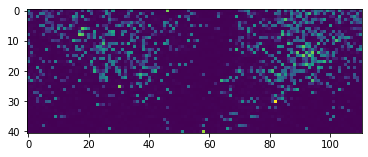

In [114]:
plt.imshow(brain[:,:,10,500].T)

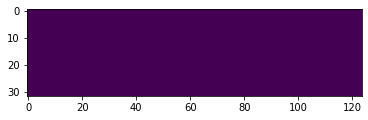

In [14]:
plt.imshow(brain_MOCO[:,:,5,1000].T)

In [115]:
file = os.path.join(load_directory,'imaging','functional_channel_1_mean.nii')
red = ants.image_read(file)

In [35]:
# file = os.path.join(load_directory,'moco','functional_channel_1_moc_mean.nii')
# red = ants.image_read(file)

ValueError: File /oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_312/func_0/moco/functional_channel_1_moc_mean.nii does not exist!

In [116]:
### CROP OFF EDGES
brain = brain[2:-2,2:-2,1:-1,:]
red = red[2:-2,2:-2,1:-1]
brain.shape

(107, 37, 13, 13600)

In [117]:
timestamps = brainsss.load_timestamps(os.path.join(load_directory, 'imaging'))

Trying to load timestamp data from hdf5 file.
Success.


In [51]:
### CROP OFF TIME
brain = brain[...,:4000]
brain.shape
timestamps = timestamps[:4000,:]

In [118]:
fictrac_raw = brainsss.load_fictrac(os.path.join(load_directory, 'fictrac'))
resolution = 10 #desired resolution in ms
fps = 100
expt_len = fictrac_raw.shape[0]/fps*1000
fictrac_raw.shape

(180000, 25)

In [119]:
fictrac_timestamps = np.arange(0,30*60*1000,10)
len(fictrac_timestamps)

180000

In [120]:
behaviors = ['dRotLabZneg', 'dRotLabZpos', 'dRotLabY', 'dRotLabZ']
fictrac = {}
z=7
for behavior,short in zip(behaviors,['R','L','F','Turn']):
    fictrac_interp = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior, timestamps=timestamps, z=z)
    fictrac[short] = fictrac_interp

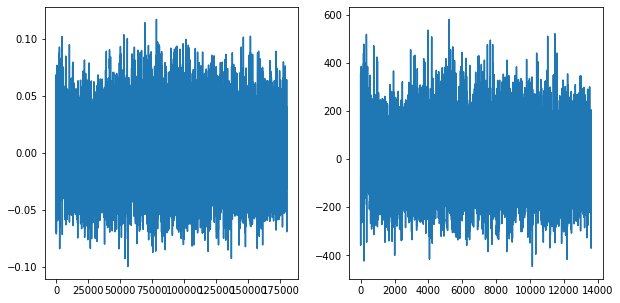

In [121]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(np.asarray(fictrac_raw['dRotLabZ']))
plt.subplot(122)
plt.plot(fictrac['Turn'])

# make supervoxels

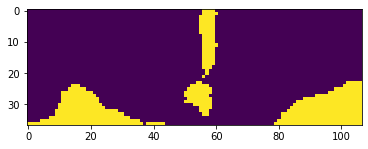

In [122]:
# mask voxels with low red signal
thresh = 300
plt.imshow(red[:,:,8].T<thresh)

In [123]:
brain[red<thresh,:] = 0

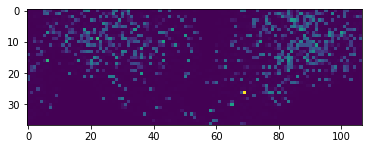

In [124]:
plt.imshow(brain[:,:,10,0].T)

In [125]:
func_path = load_directory

### MAKE CLUSTER DIRECTORY ###

cluster_dir = os.path.join(func_path, 'clustering')
if not os.path.exists(cluster_dir):
    os.mkdir(cluster_dir)

In [126]:
dims = {'x':brain.shape[0],
        'y':brain.shape[1],
        'z':brain.shape[2],
        't':brain.shape[3]}

In [127]:
### FIT CLUSTERS ###

n_clusters = 200

connectivity = grid_to_graph(dims['x'],dims['y'],dims['z'])

neural_activity = brain.reshape(-1, dims['t'])
cluster_model = AgglomerativeClustering(n_clusters=n_clusters,
                            memory=cluster_dir,
                            linkage='ward',
                            connectivity=connectivity)
cluster_model.fit(neural_activity)
cluster_labels = cluster_model.labels_

cluster_labels = np.asarray(cluster_labels)
save_file = os.path.join(cluster_dir, 'cluster_labels.npy')
np.save(save_file,cluster_labels)

/home/users/brezovec/.local/lib/python3.6/site-packages/sklearn/cluster/_hierarchical.py:856: UserWarning: Persisting input arguments took 5.01s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **kwargs)


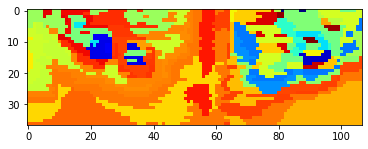

In [128]:
cluster_labels_3d = np.reshape(cluster_labels,(dims['x'],dims['y'],dims['z']))
plt.imshow(cluster_labels_3d[:,:,7].T,cmap='jet')

In [129]:
### GET CLUSTER AVERAGE SIGNAL ###
signals = []
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_labels==cluster_num)[0]
    mean_signal = np.mean(neural_activity[cluster_indicies,:], axis=0)
    signals.append(mean_signal)
signals = np.nan_to_num(np.asarray(signals)).astype('float64')
print(signals.shape)
    
save_file = os.path.join(cluster_dir, 'cluster_signals.npy')
np.save(save_file, signals)

(200, 13600)


In [ ]:
corrs = {}
for behavior in ['R','L']:
    corrs_ = []
    for cluster_num in range(n_clusters):
        corr = scipy.stats.pearsonr(fictrac[behavior], signals[cluster_num,:])[0]
        corrs_.append(corr)
    corrs[behavior] = corrs_

(array([43., 74., 39., 12.,  9.,  7.,  7.,  4.,  2.,  3.]),
 array([-2.75802956e-02,  1.03580154e-04,  2.77874560e-02,  5.54713317e-02,
         8.31552075e-02,  1.10839083e-01,  1.38522959e-01,  1.66206835e-01,
         1.93890711e-01,  2.21574587e-01,  2.49258462e-01]),
 <a list of 10 Patch objects>)

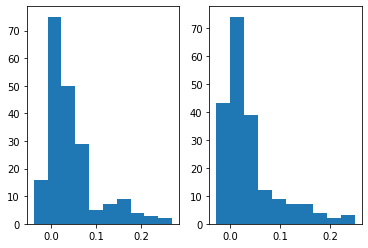

In [ ]:
plt.subplot(121)
plt.hist(corrs['L'])
plt.subplot(122)
plt.hist(corrs['R'])

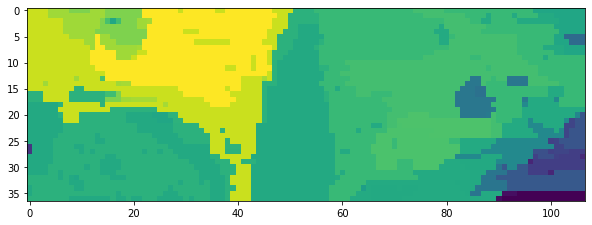

In [ ]:
behavior = 'L'

map_ = np.zeros(len(cluster_labels))
for cluster_num in range(n_clusters):
    idx = np.where(cluster_labels==cluster_num)[0]
    map_[idx] = corrs[behavior][cluster_num]
map_ = np.reshape(map_,(dims['x'],dims['y'],dims['z']))

plt.figure(figsize=(10,10))
plt.imshow(np.max(map_,axis=2).T)

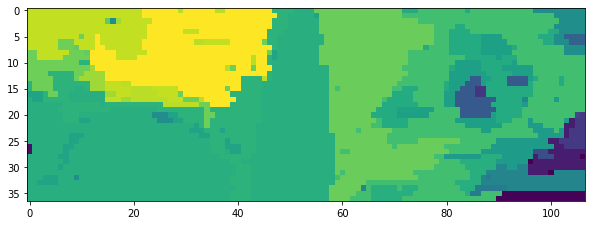

In [ ]:
behavior = 'R'

map_ = np.zeros(len(cluster_labels))
for cluster_num in range(n_clusters):
    idx = np.where(cluster_labels==cluster_num)[0]
    map_[idx] = corrs[behavior][cluster_num]
map_ = np.reshape(map_,(dims['x'],dims['y'],dims['z']))

plt.figure(figsize=(10,10))
plt.imshow(np.max(map_,axis=2).T)

In [71]:
np.argsort(np.nan_to_num(corrs['R']))

array([149,  77, 114, 173,  68, 145,  44, 139, 162,  76, 112, 163,  99,
       176,  48, 143, 194, 100, 191,  62,  95,  85,  65, 181, 125,  19,
        60, 166,  41, 188,   4, 185, 113,  66,  75,  88, 169, 147, 120,
       170,  38, 140, 110,  82,   8, 182, 101,  93, 146,  37, 192,  46,
        12,  51,  57, 180,  26, 196, 150, 129,  25,  74,  90, 156, 128,
        24, 103, 121, 183,  69,  91, 158, 168,   2, 122,  84, 154, 109,
       144,  80, 160,  10,  92, 159, 102, 184, 193,  96,  27,  89,  20,
       167,  72,  21, 190,  98,  55,  78, 197,  73,  14,  94,  45, 161,
        67, 195, 148,  52,  30,  79,  17, 105, 131, 123, 165, 119, 104,
        71,  42, 126,  29, 164,  33,   5,  86, 117,  31,  34, 127, 186,
       155,  53, 106,   7,  32,  11, 174, 152, 153, 137, 130, 198,   0,
        97, 199,  15, 175, 142,  36, 179,  49, 141, 138,   6, 171,  64,
        23, 115,  59,  63,  87, 187, 157,  47, 136, 107,  61, 124, 178,
       118, 133,  50, 135,  35, 116,  81,  18, 111,  39, 108,  8

In [62]:
timestep = np.diff(timestamps[:,0])[0] #is units of ms
window_30s = int(1000*30/timestep)

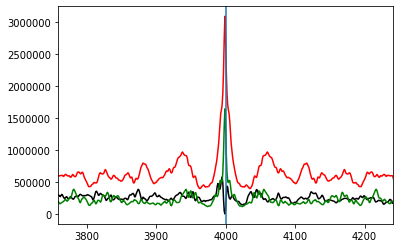

In [63]:
cc = scipy.signal.correlate(fictrac['L'], fictrac['R'])
plt.plot(cc,color='k')

cc = scipy.signal.correlate(fictrac['L'], fictrac['L'])
plt.plot(cc,color='green')

cc = scipy.signal.correlate(fictrac['R'], fictrac['R'])
plt.plot(cc,color='red')

plt.xlim(dims['t']-window_30s,dims['t']+window_30s)
plt.axvline(dims['t'])

In [73]:
sym_filter = []
for cluster_num in range(n_clusters):
    
    cc_R = scipy.signal.correlate(signals[cluster_num,:], fictrac['R'])
    cc_L = scipy.signal.correlate(signals[cluster_num,:], fictrac['L'])
    
    #cc_R = gaussian_filter1d(cc_R,sigma=3)
    #cc_L = gaussian_filter1d(cc_L,sigma=3)
    
    sym_filter.append(cc_R-cc_L)
sym_filter = np.asarray(sym_filter)
sym_filter.shape

(200, 7999)

In [305]:
thresh = 0.04
idx = np.where(np.asarray(corrs['L'])>thresh)[0]
sym_filter_threshed = sym_filter[idx,:]
sym_filter_threshed.shape

(22, 27199)

In [129]:
diff = np.abs(np.mean(sym_filter[:,13450:13550],axis=1))

In [306]:
diff = np.abs(np.mean(sym_filter_threshed[:,13450:13550],axis=1))

(array([2., 2., 1., 1., 6., 4., 3., 1., 0., 2.]),
 array([162.04650631, 204.79070736, 247.53490841, 290.27910946,
        333.02331051, 375.76751156, 418.51171261, 461.25591366,
        504.00011471, 546.74431576, 589.48851681]),
 <a list of 10 Patch objects>)

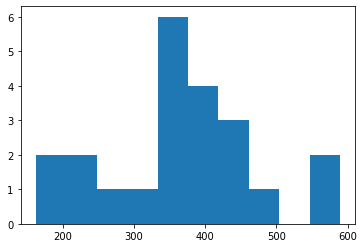

In [307]:
plt.hist(diff)

In [308]:
idx[np.argsort(diff)]

array([  0, 109,  30, 132, 118,  18,  96,  91, 174,  89,  32, 166,  47,
        28,  83,  54, 103, 188,  48, 110,  50, 128])

In [133]:
np.argsort(diff)

array([42, 18, 61, 63, 11, 26, 45,  6, 29, 13, 30, 47, 17, 62, 14, 12, 69,
       39,  1, 10,  3, 38, 37, 16, 64, 71, 15, 52, 66,  7, 31, 36, 44, 24,
        5, 33,  9, 35, 40, 25, 23, 20, 57, 56, 72, 34, 65, 48, 41, 21, 70,
       46,  8, 68, 58, 28, 32, 49, 19,  0, 55, 27,  2, 67, 51, 53,  4, 50,
       43, 22, 60, 54, 59])

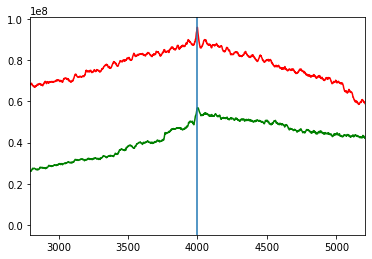

In [77]:
cluster_num = 58

cc_R = scipy.signal.correlate(signals[cluster_num,:], fictrac['R'])
cc_L = scipy.signal.correlate(signals[cluster_num,:], fictrac['L'])

#cc_R = gaussian_filter1d(cc_R,sigma=3)
#cc_L = gaussian_filter1d(cc_L,sigma=3)

plt.plot(cc_R,color='red')
plt.plot(cc_L,color='green')

plt.xlim(dims['t']-window_30s*5,dims['t']+window_30s*5)
plt.axvline(dims['t'])

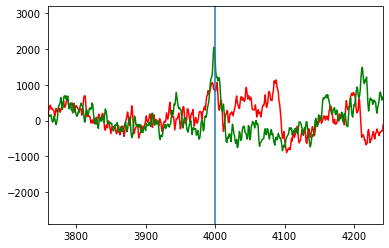

In [156]:
cluster_num = 2

cc_R = scipy.signal.correlate(signals[cluster_num,:], fictrac['R'])
cc_L = scipy.signal.correlate(signals[cluster_num,:], fictrac['L'])

#cc_R = gaussian_filter1d(cc_R,sigma=3)
#cc_L = gaussian_filter1d(cc_L,sigma=3)

plt.plot(cc_R,color='red')
plt.plot(cc_L,color='green')

plt.xlim(dims['t']-window_30s,dims['t']+window_30s)
plt.axvline(dims['t'])

In [155]:
a = [0,1,0,0,0] #neural
b = [0,0,1,0,0] #behavior
scipy.signal.correlate(a,b)
#### Here, a comes first

array([0, 0, 0, 1, 0, 0, 0, 0, 0])

# no supervoxels

In [ ]:
# fly = 317
# func = 'func_0'
# load_directory = f'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_{fly}/{func}/imaging'
# brain_file = os.path.join(load_directory, 'functional_channel_2.nii')
# brain = ants.image_read(brain_file).numpy()
# print(brain.shape)

# load_directory = f'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_{fly}/{func}'


In [2]:
fly = 312
func = 'func_0'
load_directory = f'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_{fly}/{func}/moco'
brain_file = os.path.join(load_directory, 'functional_channel_2_moco.h5')
with h5py.File(brain_file, 'r') as hf:
    brain = hf['data'][:]
#brain.shape
#brain = ants.image_read(brain_file).numpy()
print(brain.shape)
load_directory = f'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_{fly}/{func}'

(124, 32, 16, 5098)


In [3]:
timestamps = brainsss.load_timestamps(os.path.join(load_directory, 'imaging'))
fictrac_raw = brainsss.load_fictrac(os.path.join(load_directory, 'fictrac'))

Trying to load timestamp data from hdf5 file.
Success.


In [4]:
### CROP OFF TIME
brain = brain[...,:4000]
brain.shape
timestamps = timestamps[:4000,:]

In [5]:

resolution = 10 #desired resolution in ms
fps = 100
expt_len = fictrac_raw.shape[0]/fps*1000
fictrac_raw.shape

behaviors = ['dRotLabZneg', 'dRotLabZpos', 'dRotLabY', 'dRotLabZ']
fictrac = {}
z=7
for behavior,short in zip(behaviors,['R','L','F','Turn']):
    fictrac_interp = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior, timestamps=timestamps, z=z)
    fictrac[short] = fictrac_interp

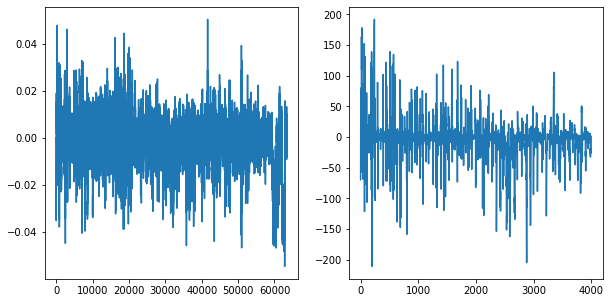

In [6]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(np.asarray(fictrac_raw['dRotLabZ']))
plt.subplot(122)
plt.plot(fictrac['Turn'])

In [7]:
dims = {'x':brain.shape[0],
        'y':brain.shape[1],
        'z':brain.shape[2],
        't':brain.shape[3]}

In [8]:
neural_activity = brain.reshape(-1, dims['t'])

In [9]:
neural_activity.shape

(63488, 4000)

In [10]:
corrs = {}
for behavior in ['R','L']:
    corrs_ = []
    for v in range(neural_activity.shape[0]):
        corr = scipy.stats.pearsonr(fictrac[behavior], neural_activity[v,:])[0]
        corrs_.append(corr)
    corrs_ = np.reshape(corrs_,(dims['x'],dims['y'],dims['z']))
    corrs[behavior] = corrs_

Text(0.5, 1.0, 'R, vmax=0.1')

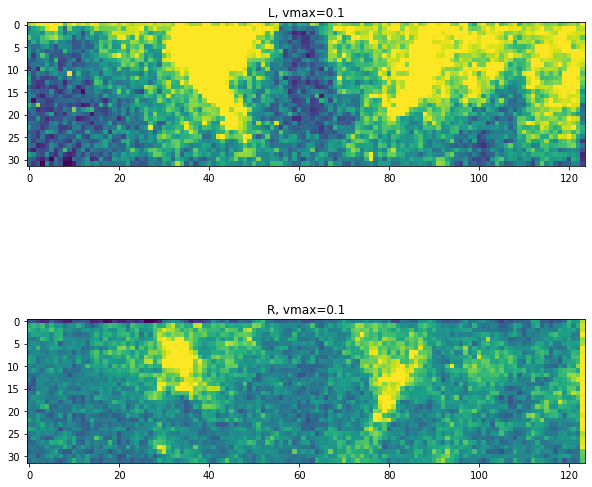

In [11]:
vmax = 0.1

plt.figure(figsize=(10,10))
plt.subplot(211)
plt.imshow(np.max(corrs['L'],axis=2).T,vmax=vmax)
plt.title(F'L, vmax={vmax}')

plt.subplot(212)
plt.imshow(np.max(corrs['R'],axis=2).T,vmax=vmax)
plt.title(F'R, vmax={vmax}')

Text(0.5, 1.0, 'R')

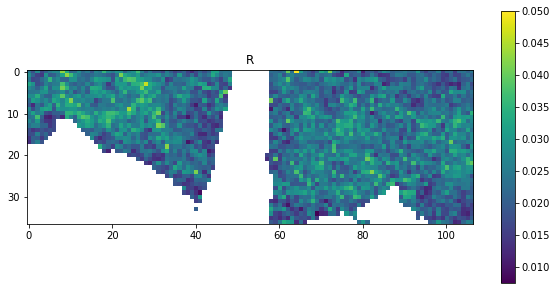

In [325]:
plt.figure(figsize=(10,5))
plt.imshow(np.max(corrs['R'],axis=2).T)
plt.colorbar()
plt.title('R')

# bout triggered version

In [387]:

# Smooth raw fictrac data
behavior = 'dRotLabZ'
fictrac_smoothed = scipy.signal.savgol_filter(np.asarray(fictrac_raw[behavior]),25,3)
fps=100
fictrac_smoothed = fictrac_smoothed * 180 / np.pi * fps # now in deg/sec

In [397]:
turn_thresh = 200

peaks = {'L':[],'R':[]}
heights = {'L':[],'R':[]}
for turn,scalar in zip(['L', 'R'],[1,-1]):

    found_peaks = scipy.signal.find_peaks(fictrac_smoothed*scalar, height=turn_thresh,distance=100)
    pks = found_peaks[0]
    pk_height = found_peaks[1]['peak_heights']

    ### remove peaks that are too close to beginning or end
    # will do 20sec window
    # here 20sec is 1000 tps
    ind = np.where(pks>88000*2)[0]
    pks = np.delete(pks,ind)
    pk_height = np.delete(pk_height,ind)

    ind = np.where(pks<2000)[0]
    pks = np.delete(pks,ind)
    pk_height = np.delete(pk_height,ind)

    peaks[turn] = pks
    heights[turn] = pk_height

In [401]:
len(peaks['L']), len(peaks['R'])

(376, 428)

(75000, 76000)

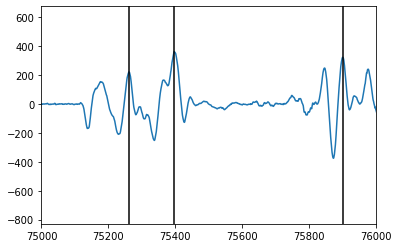

In [400]:
plt.plot(fictrac_smoothed)
for peak in peaks['L']:
    plt.axvline(peak,color='k')
plt.xlim(75000,76000)

In [403]:
##################################################
### VERSION WITH FIRST NEURAL POINT AFTER TURN ###
##################################################
### change window to 60 instead of 40 for seeing full 30sec

neural_traces_L = {}
neural_traces_R = {}

neural_timestamps_cluster = timestamps[:,7]

for v in tqdm.tqdm(range(neural_activity.shape[0])):
    
    neural_traces_L[v] = []
    neural_traces_R[v] = []

    for beh in ['L', 'R']:

        peaks_in_ms = fictrac_timestamps[peaks[beh]]

        for peak in peaks_in_ms:

            #this will give the index of the first neural data after the peak
            # 40 index will be the bin from 0 to 532ms after the peak
            middle = np.searchsorted(neural_timestamps_cluster,peak)
            if beh == 'L':
                neural_traces_L[v].append(neural_activity[v,middle-300:middle+300])
            elif beh == 'R':
                neural_traces_R[v].append(neural_activity[v,middle-300:middle+300])

    neural_traces_L[v] = np.asarray(neural_traces_L[v])
    neural_traces_R[v] = np.asarray(neural_traces_R[v])

100%|██████████| 51467/51467 [03:21<00:00, 255.57it/s]


In [417]:
neural_traces_L[24375][-100]

array([-8.975758e-09, -8.975758e-09, -8.975758e-09, -8.975758e-09,
       -8.975758e-09, -8.975758e-09, -8.975758e-09, -8.975758e-09,
       -8.975758e-09, -8.975758e-09, -8.975758e-09, -8.975758e-09,
       -8.975758e-09, -8.975758e-09, -8.975758e-09, -8.975758e-09,
       -8.975758e-09, -8.975758e-09, -8.975758e-09, -8.975758e-09,
       -8.975758e-09, -8.975758e-09, -8.975758e-09, -8.975758e-09,
       -8.975758e-09, -8.975758e-09, -8.975758e-09, -8.975758e-09,
       -8.975758e-09, -8.975758e-09, -8.975758e-09, -8.975758e-09,
       -8.975758e-09, -8.975758e-09, -8.975758e-09, -8.975758e-09,
       -8.975758e-09, -8.975758e-09, -8.975758e-09, -8.975758e-09,
       -8.975758e-09, -8.975758e-09, -8.975758e-09, -8.975758e-09,
       -8.975758e-09, -8.975758e-09, -8.975758e-09, -8.975758e-09,
       -8.975758e-09, -8.975758e-09, -8.975758e-09, -8.975758e-09,
       -8.975758e-09, -8.975758e-09, -8.975758e-09, -8.975758e-09,
       -8.975758e-09, -8.975758e-09, -8.975758e-09, -8.975758e

In [404]:
len(neural_traces_L[0])

376

In [405]:
np.asarray(neural_traces_L[24375][60:]).shape

(316,)

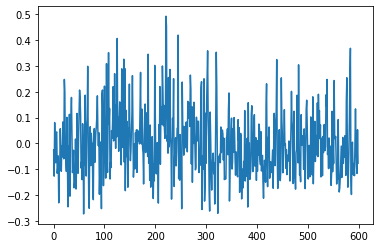

In [377]:
plt.plot(np.mean(np.asarray(neural_traces_L[24375][60:]),axis=0))

In [364]:
plt.plot(np.mean(neural_traces_L[24375]))

ValueError: operands could not be broadcast together with shapes (0,) (600,) 

In [361]:
np.argmax(corrs['L'].flatten())

24375